In [1]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)
from combiners import EpochsCombiner
from typing import *
import mne
import tensorflow as tf
import mneflow as mf
import matplotlib.pyplot as plt
import numpy as np

2022-02-08 04:52:55.382306: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-08 04:52:55.382333: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
content_root = '../'
subjects_folder_path = os.path.join(content_root, 'Source/Subjects')
subject_path = os.path.join(subjects_folder_path, 'Az_Mar_05')
info_path = os.path.join(subject_path, 'Info',
                        'ML_Subject05_P1_tsss_mc_trans_info.pkl')
resp_lock_lm_B1_epochs_path = os.path.join(
    subject_path, 'Epochs', 'RespCor_LM_B1_epochs.fif')
resp_lock_rm_B1_epochs_path = os.path.join(
    subject_path, 'Epochs', 'RespCor_RM_B1_epochs.fif')
resp_lock_li_B1_epochs_path = os.path.join(
    subject_path, 'Epochs', 'RespCor_LI_B1_epochs.fif')
resp_lock_ri_B1_epochs_path = os.path.join(
    subject_path, 'Epochs', 'RespCor_RI_B1_epochs.fif')
resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)
resp_lock_li_B1_epochs = mne.read_epochs(resp_lock_li_B1_epochs_path)
resp_lock_rm_B1_epochs = mne.read_epochs(resp_lock_rm_B1_epochs_path)
resp_lock_ri_B1_epochs = mne.read_epochs(resp_lock_ri_B1_epochs_path)

resp_lock_li_B1_epochs.resample(200)
resp_lock_lm_B1_epochs.resample(200)
resp_lock_ri_B1_epochs.resample(200)
resp_lock_rm_B1_epochs.resample(200)

combiner = EpochsCombiner(
    resp_lock_lm_B1_epochs.copy(),
    resp_lock_li_B1_epochs.copy(),
    resp_lock_rm_B1_epochs.copy(),
    resp_lock_ri_B1_epochs.copy()
)
first_class_indices = (0, 1)
second_class_indices = (2, 3)
combiner.combine(first_class_indices, second_class_indices, shuffle=True)

import_opt = dict(
        savepath='../Source/Subjects/Az_Mar_05/TFR/left_vs_right/',
        out_name='fingers_movement_epochs',
        fs=200,
        input_type='trials',
        target_type='int',
        picks={'meg': 'grad'},
        scale=True,
        crop_baseline=True,
        decimate=None,
        scale_interval=(0, 60),
        n_folds=5,
        overwrite=True,
        segment=False,
        test_set='holdout'
    )

#fake data
# X = np.random.rand(117, 204, 200)
# Y = np.array([np.heaviside(np.random.rand(117) - .5, 0)])
X = combiner.X
Y = combiner.Y
meta = mf.produce_tfrecords((X, Y), **import_opt)

dataset = mf.Dataset(meta, train_batch=100)


lf_params = dict(
        n_latent=32,
        filter_length=50,
        nonlin=tf.keras.activations.elu,
        padding='SAME',
        pooling=10,
        stride=10,
        pool_type='max',
        model_path=import_opt['savepath'],
        dropout=.4,
        l2_scope=["weights"],
        l2=1e-6
)

model = mf.models.LFCNN(dataset, lf_params)
model.build()


Reading ../Source/Subjects/Az_Mar_05/Epochs/RespCor_LM_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Reading ../Source/Subjects/Az_Mar_05/Epochs/RespCor_LI_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_2009421/2070013433.py:14: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_LM_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)
/tmp/ipykernel_2009421/2070013433.py:15: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_LI_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_li_B1_epochs = mne.read_epochs(resp_lock_li_B1_epochs_path)


Not setting metadata
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
Reading ../Source/Subjects/Az_Mar_05/Epochs/RespCor_RM_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Reading ../Source/Subjects/Az_Mar_05/Epochs/RespCor_RI_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_2009421/2070013433.py:16: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_RM_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_rm_B1_epochs = mne.read_epochs(resp_lock_rm_B1_epochs_path)
/tmp/ipykernel_2009421/2070013433.py:17: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_RI_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_ri_B1_epochs = mne.read_epochs(resp_lock_ri_B1_epochs_path)


importing from tuple
input shapes: X- (117, 204, 200) targets- (117, 1)
Preprocessing:
Scaling to interval 0.0 - 60.0
Splitting sets
Preprocessed: (117, 1, 200, 204) (117, 2) folds: 6 x 19
Prepocessed sample shape: (1, 200, 204)
Target shape actual/metadata:  (2,) (2,)
Saving TFRecord# 0


2022-02-08 04:53:01.593580: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-08 04:53:01.593607: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-08 04:53:01.593622: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arcolinux-machine): /proc/driver/nvidia/version does not exist
2022-02-08 04:53:01.593879: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Setting reg for dmx, to l2
Built: dmx input: (None, 1, 200, 204)
Setting reg for tconv, to l2
Built: tconv input: (None, 1, 200, 32)
Setting reg for fc, to l1
Built: fc input: (None, 1, 20, 32)
Input shape: (1, 200, 204)
y_pred: (None, 2)
Initialization complete!


In [4]:
from LFCNN_decoder import SpatialParameters
import pickle

def read_pkl(path: str) -> Any:
    with open(
            path,
            'rb'
        ) as file:
        content = pickle.load(
            file
        )
    return content

spatial_parameters = read_pkl('../Source/Subjects/Ga_Fed_06/Parameters/LM&LI_vs_RM&RI_B1-B8.pkl')

In [59]:
model.compute_patterns('../Source/Subjects/Ga_Fed_06/TFR/LM&LI_vs_RM&RI_B1-B8/fingers_movement_epochs_train_0.tfrecord')

In [8]:
print(spatial_parameters.patterns.shape)

(204, 32)


In [9]:
def plot_patterns(patterns, info, cmap='RdBu_r', sensors=True,
                colorbar=False, res=64,
                size=1, cbar_fmt='%3.1f', name_format='Latent\nSource %01d',
                show=True, show_names=False, title=None,
                outlines='head', contours=6,
                image_interp='bilinear'):
    if not title:
        title=f'All patterns'
    n_components = patterns.shape[1]
    import copy
    info = copy.deepcopy(info)
    info['sfreq'] = 1.
    patterns = mne.EvokedArray(patterns, info, tmin=0)
    return patterns.plot_topomap(
        times=range(n_components),
        cmap=cmap, colorbar=colorbar, res=res,
        cbar_fmt=cbar_fmt, sensors=sensors, units=None, time_unit='s',
        time_format=name_format, size=size, show_names=show_names,
        title=title, outlines=outlines,
        contours=contours, image_interp=image_interp, show=show, scalings=np.max(patterns.data[:, model.uorder]))


plot_patterns(spatial_parameters.patterns, resp_lock_li_B1_epochs.info, 'l2')

AttributeError: 'EvokedArray' object has no attribute 'shape'

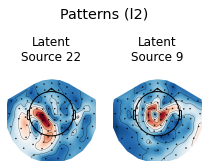

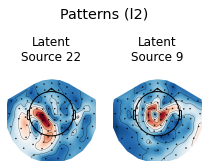

In [60]:

plot_patterns(model, resp_lock_li_B1_epochs.info, 'l2')

{'train_paths': ['../Source/Subjects/Az_Mar_05/TFR/left_vs_right/fingers_movement_epochs_train_0.tfrecord'],
 'val_paths': [],
 'test_paths': ['../Source/Subjects/Az_Mar_05/TFR/left_vs_right/fingers_movement_epochs_test_0.tfrecord'],
 'folds': [[array([110,  25,  77,  73,   3,  13, 102,  52,  66,  85,  55, 100,  56,
           99,  39,  93,  43,  89,  16]),
   array([ 71,  92,  19,  96,  45,  58,  37,  82,  35, 101,  46,  97,  28,
            9,  49,  88,   0, 103,  87]),
   array([ 10, 111,  61,  14,  98,  74,  38,  81,  69,  76,  23,   2,  63,
           20,  22,  54,  64,  41,  18]),
   array([ 36,  67,  17,  29,  53, 113,   7,  72, 106, 115,  12,  90,  15,
           68,  80,  78,  95,  59,  84]),
   array([ 30,  31,  57,  83,   8,  44,  50,  51,  65, 107,  94,  26,  75,
            6,  24,  21,  86,  70,  48])]],
 'test_fold': [array([109, 105,  40, 112, 114,  79,   1,  91,  60,  42,  33,   5,  47,
         104,   4,  62, 116,  27, 108])],
 'data_id': 'fingers_movement_epochs',
 '